In [1]:
#Импортируем библиотеки
from multiprocessing import Pool
import codecs
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot
%matplotlib inline

In [2]:
data = pd.read_csv("posts_all.csv", encoding="utf-8")
data.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1916 entries, 0 to 1916
Data columns (total 3 columns):
id           1916 non-null int64
text         1916 non-null object
Sentiment    1916 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.9+ KB


,id,text,Sentiment
1912,4852,[DevExpress Support Team: CLONED FROM [T870233...,2.0
1913,4853,[DevExpress Support Team: CLONED FROM [T870330...,2.0
1914,4854,[DevExpress Support Team: CLONED FROM [T870173...,2.0
1915,4855,"I gave you a 9, just so you don't think you ar...",4.0
1916,4856,"Hi ,After some additional research I've found ...",1.0


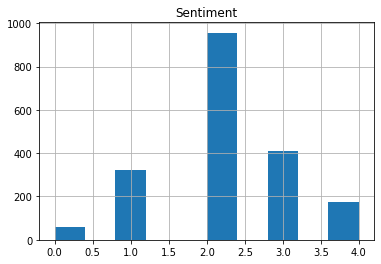

In [3]:
data.info()
#Гистограмма распределения классов 
data.hist(column=["Sentiment"])
data.tail()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021564E69F28>]],
      dtype=object)

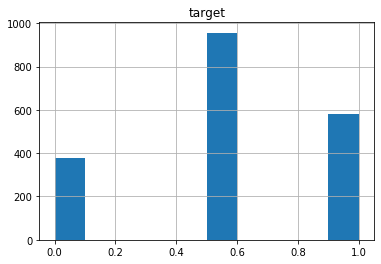

In [4]:
data["target"] = data.Sentiment.apply(lambda x: 1 if x > 2 else 0 if x < 2 else 0.5)
data.hist(column=["target"])

In [6]:
#The data store in really imbalanced
#Let's try the over sampling technice

import random 
classes = np.unique(data.target.values)
amount_classes = data.groupby("target").count().id.values
max_amount = max(amount_classes)
for cl_index in range(len(classes)):
    cl = classes[cl_index]
    cl_slice = data[data.target == cl]
    amount = amount_classes[cl_index]
    samples_to_add = max_amount - amount
    while samples_to_add > 0:
        sample_index = random.randint(0, amount - 1)

        data = data.append(cl_slice.iloc[sample_index])
        samples_to_add -= 1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2868 entries, 0 to 1411
Data columns (total 4 columns):
id           2868 non-null int64
text         2868 non-null object
Sentiment    2868 non-null float64
target       2868 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 112.0+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002156AB8AEB8>]],
      dtype=object)

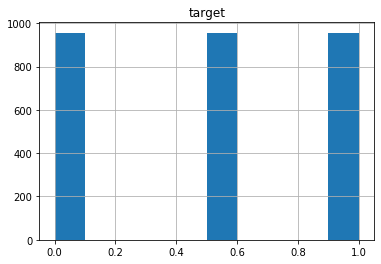

In [7]:
data.info()
data.hist(column=["target"])

In [8]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC

X = data.text.values
Y = data.target.values

In [9]:
#Импортируем доп библиотеки
from sklearn.pipeline import Pipeline
#Подбор лучших параметров
from sklearn.model_selection import GridSearchCV

#Функция создания каскада - пайплайна из ветроризатора, трансформатора и класификатора
def text_classifier(vectorizer, classifier, transformer=None):
    if (transformer is None) :
        return Pipeline(
                [("vectorizer", vectorizer),
                 ("classifier", classifier)]
            )
    else: 
        return Pipeline(
            [("vectorizer", vectorizer),
             ("transformer", transformer),
            ("classifier", classifier)]
        )

In [ ]:
# the best parameters search for the level 1 estimator
ngram_range = [(2,4),(2,5),(3,5),(2,6),(3,6),(4,6)]
param_grid = {
    "vectorizer": [TfidfVectorizer(), CountVectorizer()],
    "vectorizer__analyzer": ["char", "char_wb", "word"],
    "vectorizer__ngram_range": ngram_range,
    "vectorizer__stop_words": [None, "english"],
    "classifier": [LinearRegression()],
    #"vectorizer__max_df": np.arange(0.95, 1.0, 0.02),
    #"vectorizer__min_df": np.arange(0.0, 0.10, 0.05),
}

pipLine = text_classifier(CountVectorizer(), LinearSVC())
gridSearchCV = GridSearchCV(pipLine, scoring="max_error", 
                            param_grid=param_grid,
                            cv=5,
                           )
gridSearchCV.fit(X, Y)

print("best params", gridSearchCV.best_params_)
print("best score", gridSearchCV.best_score_)

In [ ]:
# the best parameters search for the level 2 estimator

Y_classes = data.Sentiment.values

ngram_range = [(2,4),(2,5),(3,5),(2,6),(3,6),(4,6)]
param_grid = {
    "vectorizer": [TfidfVectorizer(), CountVectorizer()],
    "vectorizer__analyzer": ["char", "char_wb", "word"],
    "vectorizer__ngram_range": ngram_range,
    "vectorizer__stop_words": [None, "english"],
    "classifier": [LogisticRegression(multi_class="multinomial", 
                                      solver="lbfgs",
                                      max_iter=120   
                                     )],
    #"vectorizer__max_df": np.arange(0.95, 1.0, 0.02),
    #"vectorizer__min_df": np.arange(0.0, 0.10, 0.05),
}

pipLine = text_classifier(CountVectorizer(), LogisticRegression())
gridSearchCV = GridSearchCV(pipLine, 
                            cv=5,
                            param_grid=param_grid)
gridSearchCV.fit(X, Y_classes)

print("best params", gridSearchCV.best_params_)
print("best score", gridSearchCV.best_score_)

In [ ]:
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(4, 6), max_df=0.95)
X_vec = vectorizer.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_vec, Y, test_size=0.33)


linear_classifier = LinearRegression()
linear_classifier.fit(X_train, Y_train)

In [ ]:
print("Train",
      linear_classifier.score(X_train, Y_train),
      "Test",
      linear_classifier.score(X_test, Y_test))

In [ ]:
l2_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_df=0.95)
X_vec_l2 = l2_vectorizer.fit_transform(X)

linear_estimation = np.array([list([v]) for v in linear_classifier.predict(X_vec)])
X_epanded = np.hstack((X_vec_l2.toarray(), linear_estimation))
Y_classes = data.Sentiment.apply(lambda x: 1 if x > 2 else -1 if x < 2 else 0).values

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X_epanded, Y_classes, test_size=0.33)


log_classifier = LogisticRegression(solver="lbfgs", 
                                    multi_class="ovr")
log_classifier.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
print("Train",
      log_classifier.score(X_train, Y_train),
      "Test",
      log_classifier.score(X_test, Y_test))

print(cross_val_score(log_classifier, X_epanded, Y_classes, cv=5))

Train 0.9389567147613762 Test 0.8898876404494382
[0.89298893 0.8962963  0.88104089 0.87686567 0.91791045]


In [57]:
print(len(X) - 1)
test_index = 1345
print(X[test_index],
      "Prediction - ",
      log_classifier.predict([X_epanded[test_index]])[0])
print("The real value is - ",
     Y_classes[test_index])
print(log_classifier.predict_proba([X_epanded[test_index]]))

1345
This was exactly what i was looking for.  
Thank you Yulia for your help. Prediction -  1
The real value is -  1
[[0.00823931 0.30631146 0.68544923]]


In [58]:
import pickle
#Сохранение данных в файл с помощью pickle
pickle.dump(linear_classifier, open( "l1_Classifier.pkl", "wb" ))
pickle.dump(vectorizer, open( "l1_vectorizer.pkl", "wb" ))
pickle.dump(log_classifier, open( "l2_Classifier.pkl", "wb" ))
pickle.dump(l2_vectorizer, open( "l2_vectorizer.pkl", "wb" ))